# Kielipankki's introduction to data analysis

This Notebook will follow up on the previous one about parsing VRT, so we will go through that part without comment.

In [2]:
# These import statements bring in modules that we're going to use
import Vrt
import datetime
import matplotlib.pyplot as plt
import numpy as np

# This is a special directive to make plots show up in the Notebook
%matplotlib notebook

from course_utils import data_dir, month_range
# Some helpers for the course environment

In [32]:
# If you have a different file, change the name here!
vrt_filename = "5M.vrt"
vrt = Vrt.VrtReader(data_dir + vrt_filename)

Let's try to make a basic plot showing the number of texts per time period. To do that, we need a list of time segments to serve as our X-axis.

In [33]:
dates = [text.date for text in vrt.texts]
min_date = min(dates)
max_date = max(dates)
# This will be the X-axis of our graph, a list of dates of the first of every month.
# month_range is a little custom function, you may want to use a more serious framework like Pandas for real work
daterange = month_range(min_date, max_date)

Then for each text in `texts` we'll assign it to a bin and increment the count of that bin. We'll do this by calculating how many months after the first element of `daterange` it is.

In [34]:
# A little helper function: the months since year 0 of a date
def month_number(date): return 12*date.year + date.month

# Subtract this from every date
min_months = month_number(daterange[0])

# First we have zero texts in every bin
counts = [0 for date in daterange]

for text in vrt.texts:
    # This text belongs in this bin
    bin_number = month_number(text.date) - min_months
    # Increment the counter for that bin
    counts[bin_number] += 1
    

Then we will use a library called `pyplot` to draw a bar chart. By convention, we have imported it as `plt`.

To nicely label the X-axis labels, we will tell `plt.xticks()` where to put them and what to call them. Then we build the chart with `plt.bar()` and finally show it inline with `plt.show()`.

<IPython.core.display.Javascript object>


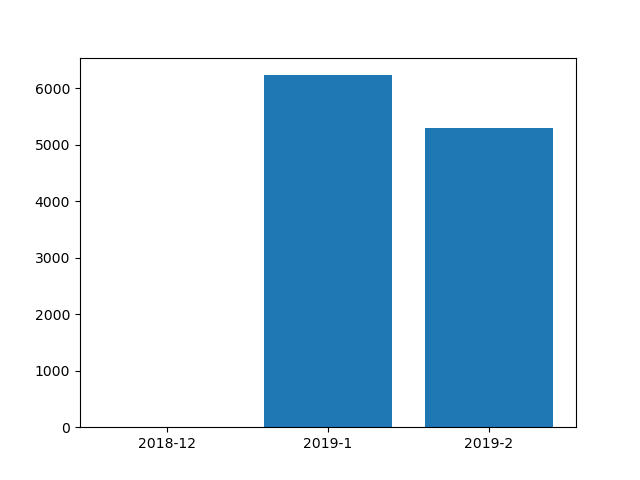

In [61]:
# The list of x-coordinates for the bars. We want as many bars as there are entries in daterange.
x_ticks = range(len(daterange))

# For each x-axis label, show just the year and month
x_labels = [f"{date.year}-{date.month}" for date in daterange]

# Give x_ticks and x_labels to pyplot
plt.xticks(ticks = x_ticks, labels = x_labels)

plt.bar(x_ticks, counts)
plt.show()

In [8]:
def gini(instances):
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    counts = {}
    for instance in instances:
        counts[instance] = counts.get(instance, 0) + 1
    array = np.array(sorted(counts.values()))
    index = np.arange(1,array.shape[0]+1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [9]:
daterange

[datetime.date(2018, 12, 1), datetime.date(2019, 1, 1)]

In [10]:
verb_tokens = [token for token in vrt.texts[0].tokens() if vrt.token_field_is_value(token, "pos", "V")]

In [11]:
verb_lemmas = vrt.map_tokens_to_field(verb_tokens, "lemma")

In [12]:
gini(verb_lemmas)

0.4143664782174925

In [13]:
def text_to_verb_gini_index(vrt, text):
    verb_tokens = [token for token in text.tokens() if vrt.token_field_is_value(token, "pos", "V")]
    verb_lemmas = vrt.map_tokens_to_field(verb_tokens, "lemma")
    return gini(verb_lemmas)

In [14]:
for text in vrt.texts[:10]: print(text_to_verb_gini_index(vrt, text))

0.4143664782174925
0.4442857142857143
0.4084934277047523
0.3296296296296296
0.40625
0.41055555555555556
0.4184852374839538
0.08333333333333333
0.4163214581607291
0.47898989898989897


In [15]:
vrt.map_tokens_to_field([token for token in vrt.texts[7].tokens() if True or vrt.token_field_is_value(token, "pos", "V")], "word")

['2',
 ':',
 '20',
 'Eeli',
 'Tolvanen',
 '-',
 '29',
 'Anton',
 'Lundell',
 '-',
 '24',
 'Kaapo',
 'Kakko',
 '7',
 'Urho',
 'Vaakanainen',
 '-',
 '2',
 'Oskari',
 'Laaksonen',
 '19.51',
 '1-0',
 'Jason',
 'Robertson',
 '(',
 'Joel',
 'Farabee',
 ')',
 '31.40',
 '2-0',
 'Tyler',
 'Madden',
 '(',
 'Josh',
 'Norris',
 ')',
 '36.42',
 '3-0',
 'Ryan',
 'Poehling',
 '(',
 'Phil',
 'Kemp',
 ')',
 '42.02',
 '4-0',
 'Tyler',
 'Madden',
 '(',
 'Josh',
 'Norris',
 ')',
 '53.16',
 '4-1',
 'Jesse',
 'Ylönen',
 '(',
 'Urho',
 'Vaakanainen',
 ',',
 'Aarne',
 'Talvitie',
 ')',
 '3',
 ':',
 '25',
 'Aarne',
 'Talvitie',
 '-',
 '22',
 'Santeri',
 'Virtanen',
 '-',
 '27',
 'Jesse',
 'Ylönen',
 '3',
 'Toni',
 'Utunen',
 '-',
 '21',
 'Otto',
 'Latvala',
 '**',
 'Yhdysvallat-Suomi',
 '4-1',
 '(',
 '1-0',
 ',',
 '2-0',
 ',',
 '1-1',
 ')',
 '**',
 '4',
 ':',
 '28',
 'Sami',
 'Moilanen',
 '-',
 '12',
 'Samuli',
 'Vainionpää',
 '-',
 '13',
 'Valtteri',
 'Puustinen',
 '36',
 'Anttoni',
 'Honka',
 'Katso',
 'suor

In [16]:
vrt.texts[7].attribs

{'datetime_content_modified': '2019-01-01T07:57:18+0200',
 'datetime_json_modified': '2019-01-01T07:57:19+0200',
 'datetime_published': '2019-01-01T05:00:05+0200',
 'datefrom': '20190101',
 'dateto': '20190101',
 'departments': '|',
 'id': '3-10577595',
 'publisher': 'Yle Urheilu',
 'timefrom': '050005',
 'timeto': '050005',
 'url': 'https://yle.fi/urheilu/3-10577595'}